# MTN Stock

In [122]:
import os
os.chdir("/content/sample_data")

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba import Mamba, MambaConfig

# Horizon 3

In [124]:
# Set default parameters
use_cuda = torch.cuda.is_available()
seed = 1
epochs = 100
lr = 0.009807515737823923
wd = 3.051959676985035e-05
hidden_dim = 48
num_layers = 2
lookback_window = 96
horizon = 3  # Set horizon as desired

def evaluation_metric(y_test, y_hat):
    MSE = mean_squared_error(y_test, y_hat)
    MAE = mean_absolute_error(y_test, y_hat)
    print('%.6f %.6f' % (MSE, MAE))

def set_seed(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

def dateinf(series, n_test):
    lt = len(series)
    print('Training start', series[0])
    print('Training end', series[lt - n_test - 1])
    print('Testing start', series[lt - n_test])
    print('Testing end', series[lt - 1])

set_seed(seed, use_cuda)

class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.config = MambaConfig(d_model=hidden_dim, n_layers=num_layers)
        self.mamba = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            Mamba(self.config),
            nn.Linear(hidden_dim, out_dim),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.mamba(x)
        return x.flatten()

def PredictWithData(trainX, trainy, valX, valy, testX):
    clf = Net(len(trainX[0]), 1)
    opt = torch.optim.Adam(clf.parameters(), lr=lr, weight_decay=wd)
    xt = torch.from_numpy(trainX).float().unsqueeze(0)  # Add batch dimension
    xv = torch.from_numpy(valX).float().unsqueeze(0)    # Add batch dimension
    xtest = torch.from_numpy(testX).float().unsqueeze(0)  # Add batch dimension
    yt = torch.from_numpy(trainy).float()
    yv = torch.from_numpy(valy).float()

    # Move data to GPU if available
    if use_cuda:
        clf = clf.cuda()
        xt, xv, xtest, yt, yv = xt.cuda(), xv.cuda(), xtest.cuda(), yt.cuda(), yv.cuda()

    train_losses = []
    val_losses = []

    # Training loop
    for e in range(epochs):
        clf.train()
        z = clf(xt)
        train_loss = F.mse_loss(z, yt)
        train_losses.append(train_loss.item())

        # Validation loss
        clf.eval()
        with torch.no_grad():
            val_pred = clf(xv)
            val_loss = F.mse_loss(val_pred, yv)
            val_losses.append(val_loss.item())

        # Backward pass and optimization
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        # Print progress every 10 epochs
        if e % 10 == 0:
            print(f'Epoch {e} | Train Loss: {train_loss.item():.4f} | Validation Loss: {val_loss.item():.4f}')

    # Test predictions
    with torch.no_grad():
        clf.eval()
        test_pred = clf(xtest)
        if use_cuda:
            test_pred = test_pred.cpu()
        yhat = test_pred.numpy().flatten()

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs (MTN Stock)')
    plt.legend()
    plt.show()

    return yhat

In [125]:
# Load data
data = pd.read_csv('/content/sample_data/MTN_stock_data.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S%z')

# Calculate the percentage change in the 'Close' price
data['pct_chg'] = data['Close'].pct_change() * 100

# Drop the first row if needed and reset the index
data = data.iloc[1:].reset_index(drop=True)

# Extract 'Close' and rate of change
close = data.pop('Close').values
ratechg = data['pct_chg'].apply(lambda x: 0.01 * x).values
data.drop(columns=['pct_chg'], inplace=True)
dat = data.iloc[:, 1:].values

# Columns to normalize
cols_to_normalize = ["Open", "High", "Low", "Adj Close", "Volume"]

# Split data into train, validation, and test
n_test = 100  # The full test set remains constant
n_val = 200
train_data = dat[:-(n_test + n_val)]
val_data = dat[-(n_test + n_val):-n_test]
test_data = dat[-n_test:]

# Calculate mean and std using training and validation sets
mean = np.mean(np.vstack((train_data, val_data))[:, [data.columns.get_loc(col) - 1 for col in cols_to_normalize]], axis=0)
std = np.std(np.vstack((train_data, val_data))[:, [data.columns.get_loc(col) - 1 for col in cols_to_normalize]], axis=0)

# Normalize train, validation, and test sets
train_data[:, [data.columns.get_loc(col) - 1 for col in cols_to_normalize]] = (train_data[:, [data.columns.get_loc(col) - 1 for col in cols_to_normalize]] - mean) / std
val_data[:, [data.columns.get_loc(col) - 1 for col in cols_to_normalize]] = (val_data[:, [data.columns.get_loc(col) - 1 for col in cols_to_normalize]] - mean) / std
test_data[:, [data.columns.get_loc(col) - 1 for col in cols_to_normalize]] = (test_data[:, [data.columns.get_loc(col) - 1 for col in cols_to_normalize]] - mean) / std

# Prepare labels for train, validation, and test
trainX, trainy = train_data, ratechg[:-(n_test + n_val)]
valX, valy = val_data, ratechg[-(n_test + n_val):-n_test]
testX = test_data[-horizon:]  # Use the last 'horizon' data points in test for prediction
testy = ratechg[-n_test:][-horizon:]  # Last 'horizon' rate changes for evaluation

Epoch 0 | Train Loss: 0.1635 | Validation Loss: 0.2051
Epoch 10 | Train Loss: 0.0039 | Validation Loss: 0.0049
Epoch 20 | Train Loss: 0.0017 | Validation Loss: 0.0017
Epoch 30 | Train Loss: 0.0007 | Validation Loss: 0.0010
Epoch 40 | Train Loss: 0.0004 | Validation Loss: 0.0005
Epoch 50 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 60 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 70 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 80 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 90 | Train Loss: 0.0003 | Validation Loss: 0.0003


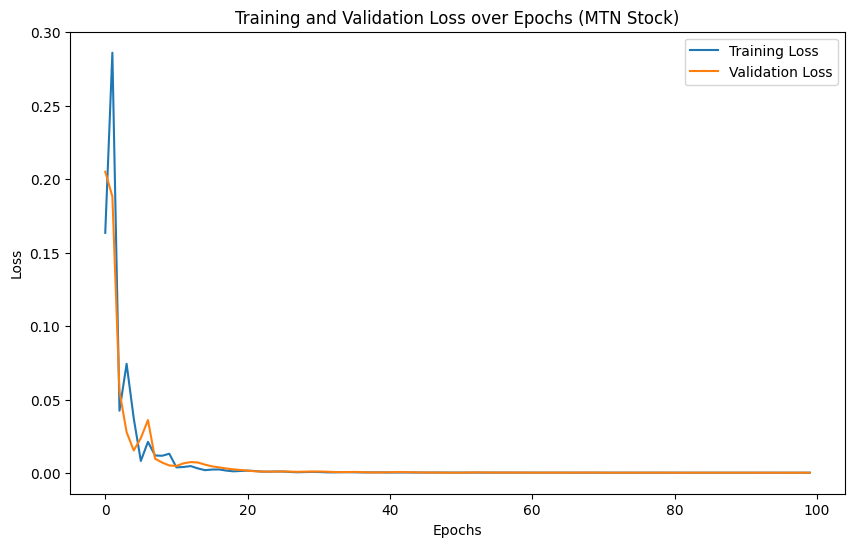

In [126]:
# Predicting
predictions = PredictWithData(trainX, trainy, valX, valy, testX)

In [127]:
# Calculate predicted stock prices for the last 'horizon' steps
time = data['Date'][-n_test:][-horizon:]
data1 = close[-n_test:][-horizon:]
finalpredicted_stock_price = []
pred = close[-n_test - 1]

# Calculate stock prices based on predictions
for i in range(horizon):
    pred = data1[i] * (1 + predictions[i])
    finalpredicted_stock_price.append(pred)

# Convert `data1` (test close prices) to ratechg
data1_pct_chg = np.diff(data1) / data1[:-1] * 100  # Calculate percentage change
test_ratechg = data1_pct_chg * 0.01  # Scale by 0.01 to match ratechg format

# Convert `finalpredicted_stock_price` (predicted close prices) to ratechg
predicted_pct_chg = np.diff(finalpredicted_stock_price) / np.array(finalpredicted_stock_price[:-1]) * 100
predicted_ratechg = predicted_pct_chg * 0.01  # Scale by 0.01

In [128]:
# Evaluate metrics
print('MSE MAE')
evaluation_metric(test_ratechg[:horizon-1], predicted_ratechg)

MSE MAE
0.000440 0.019940


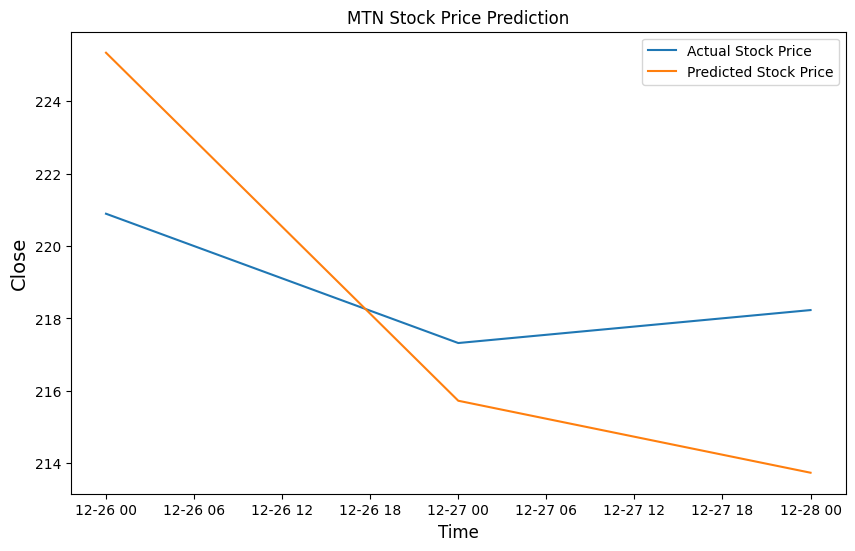

In [129]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Actual Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('MTN Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# Horizon 5

In [130]:
def PredictWithData(trainX, trainy, valX, valy, testX):
    clf = Net(len(trainX[0]), 1)
    opt = torch.optim.Adam(clf.parameters(), lr=lr, weight_decay=wd)
    xt = torch.from_numpy(trainX).float().unsqueeze(0)  # Add batch dimension
    xv = torch.from_numpy(valX).float().unsqueeze(0)    # Add batch dimension
    xtest = torch.from_numpy(testX).float().unsqueeze(0)  # Add batch dimension
    yt = torch.from_numpy(trainy).float()
    yv = torch.from_numpy(valy).float()

    # Move data to GPU if available
    if use_cuda:
        clf = clf.cuda()
        xt, xv, xtest, yt, yv = xt.cuda(), xv.cuda(), xtest.cuda(), yt.cuda(), yv.cuda()

    train_losses = []
    val_losses = []

    # Training loop
    for e in range(epochs):
        clf.train()
        z = clf(xt)
        train_loss = F.mse_loss(z, yt)
        train_losses.append(train_loss.item())

        # Validation loss
        clf.eval()
        with torch.no_grad():
            val_pred = clf(xv)
            val_loss = F.mse_loss(val_pred, yv)
            val_losses.append(val_loss.item())

        # Backward pass and optimization
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        # Print progress every 10 epochs
        if e % 10 == 0:
            print(f'Epoch {e} | Train Loss: {train_loss.item():.4f} | Validation Loss: {val_loss.item():.4f}')

    # Test predictions
    with torch.no_grad():
        clf.eval()
        test_pred = clf(xtest)
        if use_cuda:
            test_pred = test_pred.cpu()
        yhat = test_pred.numpy().flatten()


    return yhat

In [131]:
horizon = 5

In [132]:
# Prepare labels for train, validation, and test
trainX, trainy = train_data, ratechg[:-(n_test + n_val)]
valX, valy = val_data, ratechg[-(n_test + n_val):-n_test]
testX = test_data[-horizon:]  # Use the last 'horizon' data points in test for prediction
testy = ratechg[-n_test:][-horizon:]  # Last 'horizon' rate changes for evaluation

In [133]:
# Predicting
predictions = PredictWithData(trainX, trainy, valX, valy, testX)

Epoch 0 | Train Loss: 0.1479 | Validation Loss: 0.0550
Epoch 10 | Train Loss: 0.0160 | Validation Loss: 0.0036
Epoch 20 | Train Loss: 0.0027 | Validation Loss: 0.0050
Epoch 30 | Train Loss: 0.0012 | Validation Loss: 0.0012
Epoch 40 | Train Loss: 0.0006 | Validation Loss: 0.0003
Epoch 50 | Train Loss: 0.0004 | Validation Loss: 0.0003
Epoch 60 | Train Loss: 0.0003 | Validation Loss: 0.0002
Epoch 70 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 80 | Train Loss: 0.0003 | Validation Loss: 0.0002
Epoch 90 | Train Loss: 0.0002 | Validation Loss: 0.0002


In [134]:
# Calculate predicted stock prices for the last 'horizon' steps
time = data['Date'][-n_test:][-horizon:]
data1 = close[-n_test:][-horizon:]
finalpredicted_stock_price = []
pred = close[-n_test - 1]

# Calculate stock prices based on predictions
for i in range(horizon):
    pred = data1[i] * (1 + predictions[i])
    finalpredicted_stock_price.append(pred)

# Convert `data1` (test close prices) to ratechg
data1_pct_chg = np.diff(data1) / data1[:-1] * 100  # Calculate percentage change
test_ratechg = data1_pct_chg * 0.01  # Scale by 0.01 to match ratechg format

# Convert `finalpredicted_stock_price` (predicted close prices) to ratechg
predicted_pct_chg = np.diff(finalpredicted_stock_price) / np.array(finalpredicted_stock_price[:-1]) * 100
predicted_ratechg = predicted_pct_chg * 0.01  # Scale by 0.01

In [135]:
# Evaluate metrics
print('MSE MAE')
evaluation_metric(test_ratechg[:horizon-1], predicted_ratechg)

MSE MAE
0.000233 0.014215


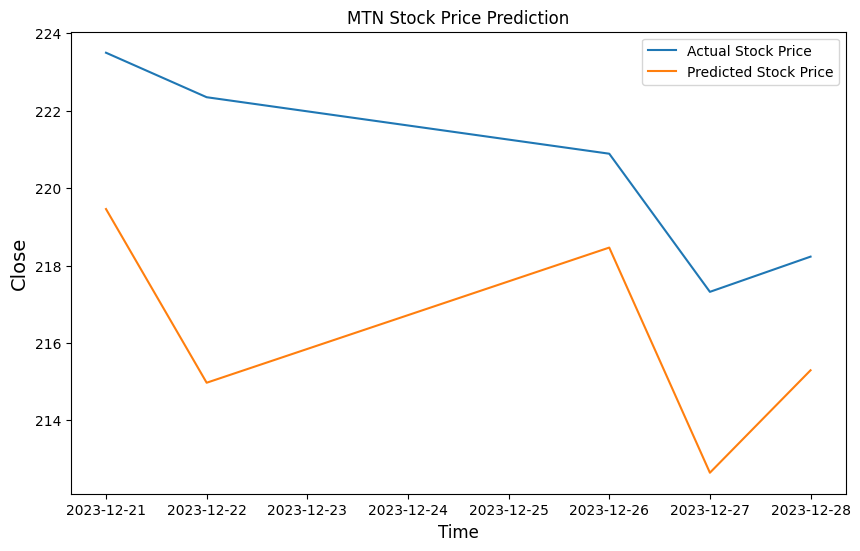

In [136]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Actual Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('MTN Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# Horizon 10

In [137]:
horizon = 10

In [138]:
# Prepare labels for train, validation, and test
trainX, trainy = train_data, ratechg[:-(n_test + n_val)]
valX, valy = val_data, ratechg[-(n_test + n_val):-n_test]
testX = test_data[-horizon:]  # Use the last 'horizon' data points in test for prediction
testy = ratechg[-n_test:][-horizon:]  # Last 'horizon' rate changes for evaluation

In [139]:
# Predicting
predictions = PredictWithData(trainX, trainy, valX, valy, testX)

Epoch 0 | Train Loss: 0.0959 | Validation Loss: 0.0572
Epoch 10 | Train Loss: 0.0053 | Validation Loss: 0.0301
Epoch 20 | Train Loss: 0.0016 | Validation Loss: 0.0016
Epoch 30 | Train Loss: 0.0007 | Validation Loss: 0.0014
Epoch 40 | Train Loss: 0.0006 | Validation Loss: 0.0009
Epoch 50 | Train Loss: 0.0004 | Validation Loss: 0.0004
Epoch 60 | Train Loss: 0.0004 | Validation Loss: 0.0003
Epoch 70 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 80 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 90 | Train Loss: 0.0003 | Validation Loss: 0.0003


In [140]:
# Calculate predicted stock prices for the last 'horizon' steps
time = data['Date'][-n_test:][-horizon:]
data1 = close[-n_test:][-horizon:]
finalpredicted_stock_price = []
pred = close[-n_test - 1]

# Calculate stock prices based on predictions
for i in range(horizon):
    pred = data1[i] * (1 + predictions[i])
    finalpredicted_stock_price.append(pred)

# Convert `data1` (test close prices) to ratechg
data1_pct_chg = np.diff(data1) / data1[:-1] * 100  # Calculate percentage change
test_ratechg = data1_pct_chg * 0.01  # Scale by 0.01 to match ratechg format

# Convert `finalpredicted_stock_price` (predicted close prices) to ratechg
predicted_pct_chg = np.diff(finalpredicted_stock_price) / np.array(finalpredicted_stock_price[:-1]) * 100
predicted_ratechg = predicted_pct_chg * 0.01  # Scale by 0.01

In [141]:
# Evaluate metrics
print('MSE MAE')
evaluation_metric(test_ratechg[:horizon-1], predicted_ratechg)

MSE MAE
0.000524 0.018960


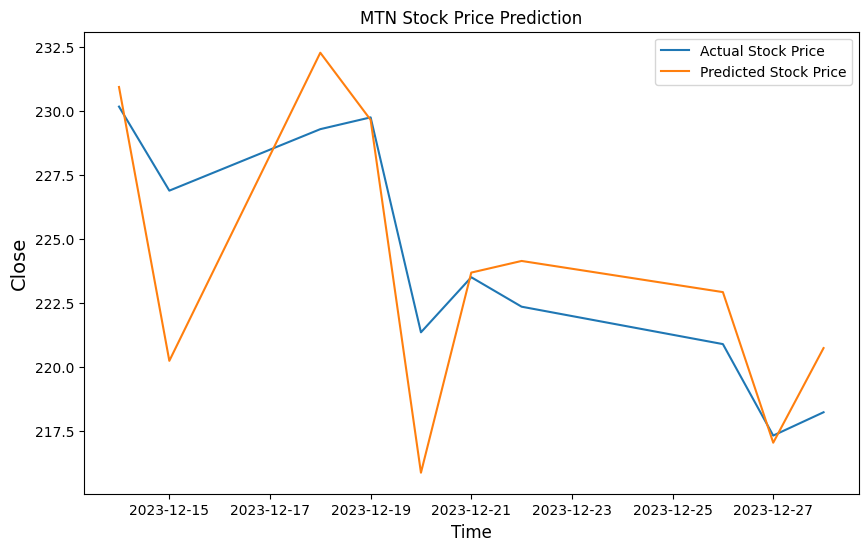

In [142]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Actual Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('MTN Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# Horizon 22

In [143]:
horizon = 22

In [144]:
# Prepare labels for train, validation, and test
trainX, trainy = train_data, ratechg[:-(n_test + n_val)]
valX, valy = val_data, ratechg[-(n_test + n_val):-n_test]
testX = test_data[-horizon:]  # Use the last 'horizon' data points in test for prediction
testy = ratechg[-n_test:][-horizon:]  # Last 'horizon' rate changes for evaluation

In [145]:
# Predicting
predictions = PredictWithData(trainX, trainy, valX, valy, testX)

Epoch 0 | Train Loss: 0.1704 | Validation Loss: 0.2543
Epoch 10 | Train Loss: 0.0046 | Validation Loss: 0.0150
Epoch 20 | Train Loss: 0.0037 | Validation Loss: 0.0061
Epoch 30 | Train Loss: 0.0004 | Validation Loss: 0.0004
Epoch 40 | Train Loss: 0.0005 | Validation Loss: 0.0004
Epoch 50 | Train Loss: 0.0004 | Validation Loss: 0.0003
Epoch 60 | Train Loss: 0.0003 | Validation Loss: 0.0002
Epoch 70 | Train Loss: 0.0003 | Validation Loss: 0.0002
Epoch 80 | Train Loss: 0.0003 | Validation Loss: 0.0002
Epoch 90 | Train Loss: 0.0003 | Validation Loss: 0.0002


In [146]:
# Calculate predicted stock prices for the last 'horizon' steps
time = data['Date'][-n_test:][-horizon:]
data1 = close[-n_test:][-horizon:]
finalpredicted_stock_price = []
pred = close[-n_test - 1]

# Calculate stock prices based on predictions
for i in range(horizon):
    pred = data1[i] * (1 + predictions[i])
    finalpredicted_stock_price.append(pred)

# Convert `data1` (test close prices) to ratechg
data1_pct_chg = np.diff(data1) / data1[:-1] * 100  # Calculate percentage change
test_ratechg = data1_pct_chg * 0.01  # Scale by 0.01 to match ratechg format

# Convert `finalpredicted_stock_price` (predicted close prices) to ratechg
predicted_pct_chg = np.diff(finalpredicted_stock_price) / np.array(finalpredicted_stock_price[:-1]) * 100
predicted_ratechg = predicted_pct_chg * 0.01  # Scale by 0.01

In [147]:
# Evaluate metrics
print('MSE MAE')
evaluation_metric(test_ratechg[:horizon-1], predicted_ratechg)

MSE MAE
0.000081 0.007095


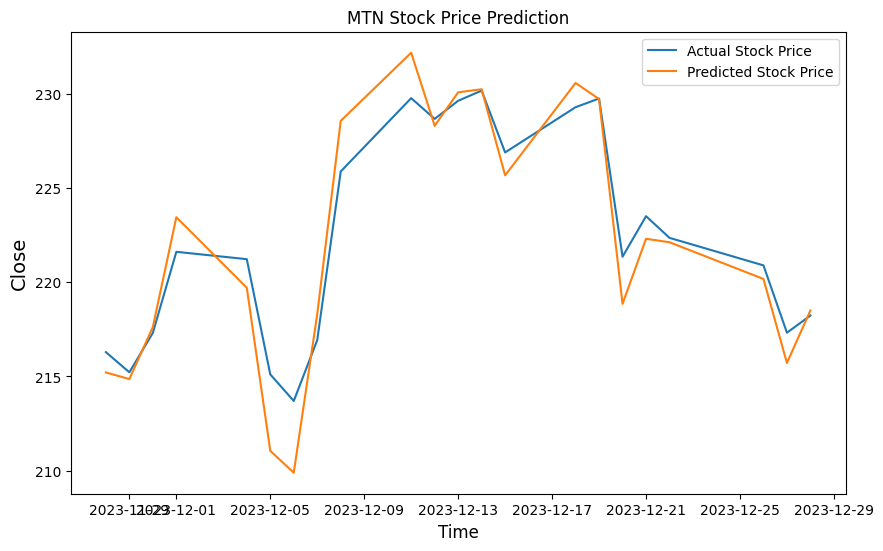

In [148]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Actual Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('MTN Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# Horizon 50

In [149]:
horizon = 50

In [150]:
# Prepare labels for train, validation, and test
trainX, trainy = train_data, ratechg[:-(n_test + n_val)]
valX, valy = val_data, ratechg[-(n_test + n_val):-n_test]
testX = test_data[-horizon:]  # Use the last 'horizon' data points in test for prediction
testy = ratechg[-n_test:][-horizon:]  # Last 'horizon' rate changes for evaluation

In [151]:
# Predicting
predictions = PredictWithData(trainX, trainy, valX, valy, testX)

Epoch 0 | Train Loss: 0.1242 | Validation Loss: 0.2152
Epoch 10 | Train Loss: 0.0409 | Validation Loss: 0.0476
Epoch 20 | Train Loss: 0.0027 | Validation Loss: 0.0031
Epoch 30 | Train Loss: 0.0010 | Validation Loss: 0.0012
Epoch 40 | Train Loss: 0.0004 | Validation Loss: 0.0006
Epoch 50 | Train Loss: 0.0004 | Validation Loss: 0.0004
Epoch 60 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 70 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 80 | Train Loss: 0.0003 | Validation Loss: 0.0003
Epoch 90 | Train Loss: 0.0003 | Validation Loss: 0.0003


In [152]:
# Calculate predicted stock prices for the last 'horizon' steps
time = data['Date'][-n_test:][-horizon:]
data1 = close[-n_test:][-horizon:]
finalpredicted_stock_price = []
pred = close[-n_test - 1]

# Calculate stock prices based on predictions
for i in range(horizon):
    pred = data1[i] * (1 + predictions[i])
    finalpredicted_stock_price.append(pred)

# Convert `data1` (test close prices) to ratechg
data1_pct_chg = np.diff(data1) / data1[:-1] * 100  # Calculate percentage change
test_ratechg = data1_pct_chg * 0.01  # Scale by 0.01 to match ratechg format

# Convert `finalpredicted_stock_price` (predicted close prices) to ratechg
predicted_pct_chg = np.diff(finalpredicted_stock_price) / np.array(finalpredicted_stock_price[:-1]) * 100
predicted_ratechg = predicted_pct_chg * 0.01  # Scale by 0.01

In [153]:
# Evaluate metrics
print('MSE MAE')
evaluation_metric(test_ratechg[:horizon-1], predicted_ratechg)

MSE MAE
0.000205 0.011765


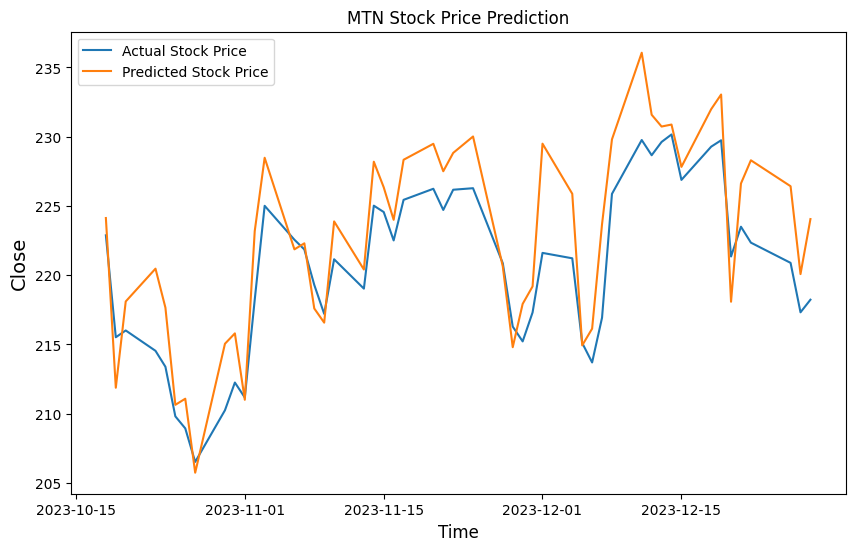

In [154]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Actual Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('MTN Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# Horizon 100

In [155]:
horizon = 50

In [156]:
# Prepare labels for train, validation, and test
trainX, trainy = train_data, ratechg[:-(n_test + n_val)]
valX, valy = val_data, ratechg[-(n_test + n_val):-n_test]
testX = test_data[-horizon:]  # Use the last 'horizon' data points in test for prediction
testy = ratechg[-n_test:][-horizon:]  # Last 'horizon' rate changes for evaluation

In [157]:
# Predicting
predictions = PredictWithData(trainX, trainy, valX, valy, testX)

Epoch 0 | Train Loss: 0.4519 | Validation Loss: 0.1519
Epoch 10 | Train Loss: 0.0078 | Validation Loss: 0.0018
Epoch 20 | Train Loss: 0.0034 | Validation Loss: 0.0008
Epoch 30 | Train Loss: 0.0011 | Validation Loss: 0.0046
Epoch 40 | Train Loss: 0.0008 | Validation Loss: 0.0034
Epoch 50 | Train Loss: 0.0005 | Validation Loss: 0.0011
Epoch 60 | Train Loss: 0.0004 | Validation Loss: 0.0008
Epoch 70 | Train Loss: 0.0004 | Validation Loss: 0.0013
Epoch 80 | Train Loss: 0.0003 | Validation Loss: 0.0009
Epoch 90 | Train Loss: 0.0003 | Validation Loss: 0.0010


In [158]:
# Calculate predicted stock prices for the last 'horizon' steps
time = data['Date'][-n_test:][-horizon:]
data1 = close[-n_test:][-horizon:]
finalpredicted_stock_price = []
pred = close[-n_test - 1]

# Calculate stock prices based on predictions
for i in range(horizon):
    pred = data1[i] * (1 + predictions[i])
    finalpredicted_stock_price.append(pred)

# Convert `data1` (test close prices) to ratechg
data1_pct_chg = np.diff(data1) / data1[:-1] * 100  # Calculate percentage change
test_ratechg = data1_pct_chg * 0.01  # Scale by 0.01 to match ratechg format

# Convert `finalpredicted_stock_price` (predicted close prices) to ratechg
predicted_pct_chg = np.diff(finalpredicted_stock_price) / np.array(finalpredicted_stock_price[:-1]) * 100
predicted_ratechg = predicted_pct_chg * 0.01  # Scale by 0.01

In [159]:
# Evaluate metrics
print('MSE MAE')
evaluation_metric(test_ratechg[:horizon-1], predicted_ratechg)

MSE MAE
0.000079 0.006556


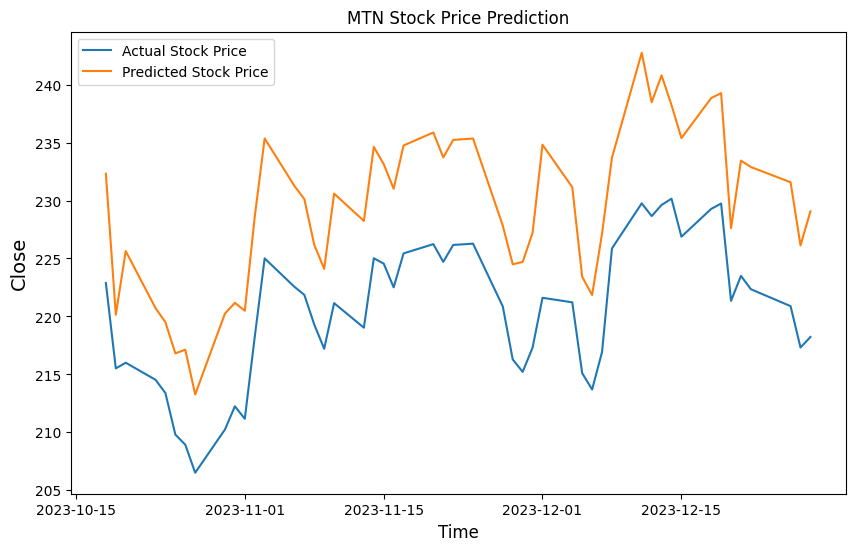

In [160]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Actual Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('MTN Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()